In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.3,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.25,
)
valid_datagen = ImageDataGenerator(
        rescale=1./255,
)

In [3]:
PATH = os.path.join(os.getcwd(), 'dataset')

train_dir = os.path.join(PATH, 'training')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
img_height = 160
img_width = 160

In [4]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    shuffle=True,
)
valid_data = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 5600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [5]:
def visualize_images(images,labels):
    figure, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 14))
    classes = list(train_data.class_indices.keys())
    img_no = 0
    for i in range(3):
        for j in range(3):
            img = images[img_no]
            lbl = np.argmax(labels[img_no])

            ax[i,j].imshow(img)
            ax[i,j].set_title(classes[lbl])
            ax[i,j].set_axis_off()
            img_no+=1

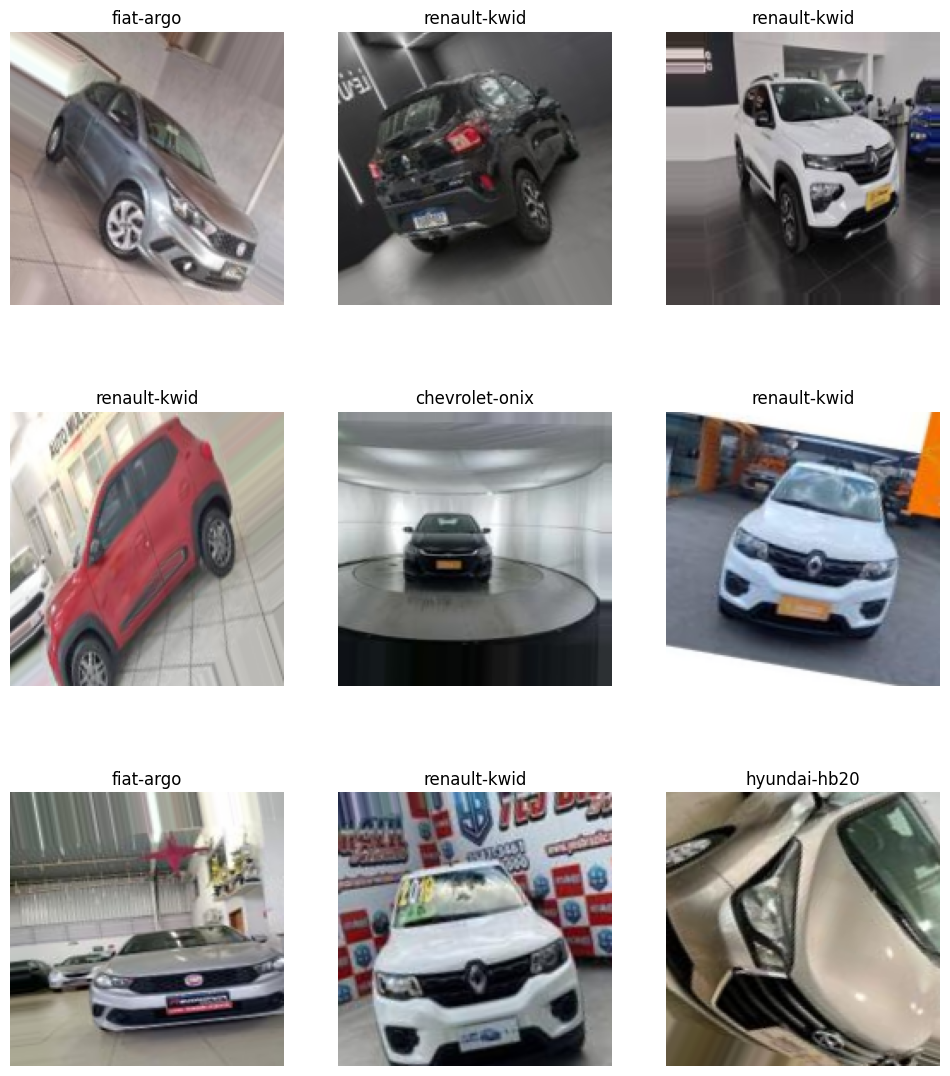

In [6]:
images, labels = next(train_data)
visualize_images(images,labels)

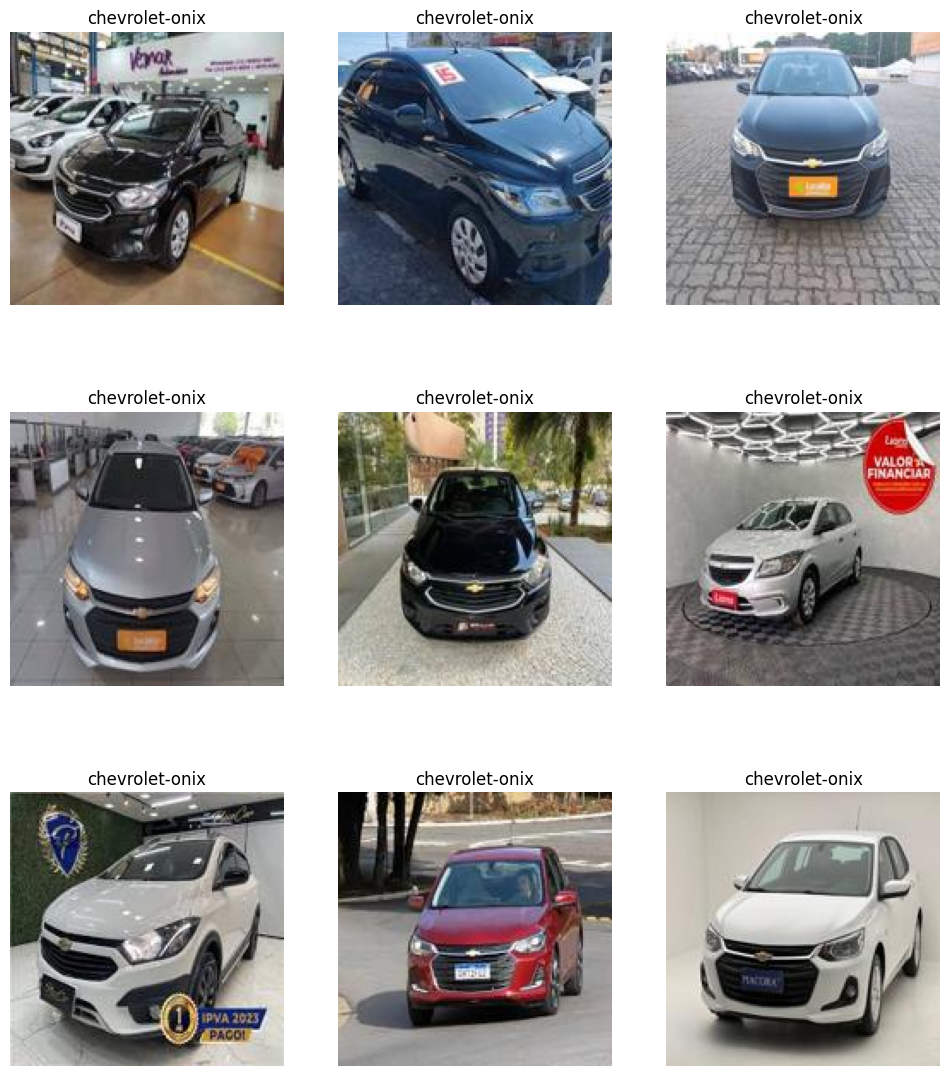

In [7]:
images, labels = next(valid_data)
visualize_images(images,labels)

In [8]:
base = MobileNetV2(input_shape=(160,160,3),include_top=False,weights='imagenet')
base.trainable = True
model = Sequential()
model.add(base)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
# opt = SGD(lr=0.001, momentum=0.9)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss = 'categorical_crossentropy',metrics=['accuracy'])

In [9]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
log = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log,write_graph=False,update_freq=100)
chkp = ModelCheckpoint('drive/MyDrive/mobilenetv2_tuned.h5',monitor='val_accuracy',verbose=1,save_best_only=True)

In [10]:
history = model.fit(train_data, 
                    epochs=20,
                    validation_data = valid_data,
                    callbacks=[early_stop, reduce_lr, tensorboard, chkp])

Epoch 1/20
175/175 [==============================] - ETA: 0s - loss: 0.8045 - accuracy: 0.6948
Epoch 1: val_accuracy improved from -inf to 0.45750, saving model to drive/MyDrive\mobilenetv2_tuned.h5
175/175 [==============================] - 40s 175ms/step - loss: 0.8045 - accuracy: 0.6948 - val_loss: 5.8929 - val_accuracy: 0.4575 - lr: 0.0010
Epoch 2/20
175/175 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.8448
Epoch 2: val_accuracy improved from 0.45750 to 0.49750, saving model to drive/MyDrive\mobilenetv2_tuned.h5
175/175 [==============================] - 29s 165ms/step - loss: 0.4719 - accuracy: 0.8448 - val_loss: 7.0449 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 3/20
175/175 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.8761
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 3: val_accuracy did not improve from 0.49750
175/175 [==============================] - 29s 162ms/step - loss: 0.3740 - acc

In [11]:
preds = model.predict(valid_data)

13/13 [==============================] - 1s 43ms/step


In [12]:
out = preds.argmax(axis=1)
out.shape

(400,)

In [13]:
from sklearn.metrics import accuracy_score
val_acc = accuracy_score(valid_data.labels,out)
print(f'Validation Accuracy: {val_acc:.2f}') 

Validation Accuracy: 0.94


In [14]:
import time
inp = np.random.randint(0,255,(1,160,160,3))
t1 = time.time()
out = model.predict(inp)
t2 = time.time()
print(f'Inference Time: {t2-t1}')
print(f'FPS: {1/(t2-t1)}')

1/1 [==============================] - 1s 1s/step
Inference Time: 1.407745361328125
FPS: 0.7103557415075116


In [15]:
import tensorflow as tf

In [16]:
class_names = list(train_data.class_indices.values())

In [22]:
car_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSo7N8pAmOaxeHcCY6yB2e-MkHwxahA-epSkg&usqp=CAU"
car_path = tf.keras.utils.get_file('car8', origin=car_url)

img = tf.keras.utils.load_img(
    car_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])
print(score)

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

1/1 [==============================] - 0s 24ms/step
[[0.11503438 0.05151778 0.09129219 0.7421557 ]]
tf.Tensor([0.20888996 0.19603457 0.20398888 0.39108655], shape=(4,), dtype=float32)


In [26]:
test_datagen    = ImageDataGenerator(rescale=1. / 255)

test_generator  = test_datagen.flow_from_directory(
    directory   = validation_dir,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = "categorical",
    shuffle     = False  )

test_generator.reset()

preds           =  model.predict(test_generator,verbose=1, steps = None)

predicted_class_indices = np.argmax(preds,axis=1)

# Next step is I want the name of the classes:

labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# create a dataframe with the image names and class predicted.

filenames     =  test_generator.filenames
results       =  pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

display(results.sample(5))

Found 400 images belonging to 4 classes.
13/13 [==============================] - 0s 32ms/step


,Filename,Predictions
331,renault-kwid\33DC8A19DF.jpg,renault-kwid
110,fiat-argo\23C5653FA0.jpg,fiat-argo
44,chevrolet-onix\1D62FB391F.jpg,chevrolet-onix
49,chevrolet-onix\1DDA09C54A.jpg,chevrolet-onix
97,chevrolet-onix\4BC2389AFA.jpg,chevrolet-onix


In [86]:
test_generator.filenames

['chevrolet-onix\\0001B4AAC3.jpg',
 'chevrolet-onix\\000EF354F1.jpg',
 'chevrolet-onix\\00BB0D1BEA.jpg',
 'chevrolet-onix\\02CFCA5683.jpg',
 'chevrolet-onix\\03A37FCB50.jpg',
 'chevrolet-onix\\04A794EBC7.jpg',
 'chevrolet-onix\\04D5011679.jpg',
 'chevrolet-onix\\04EDE2C25E.jpg',
 'chevrolet-onix\\04F194086B.jpg',
 'chevrolet-onix\\0A13C6689E.jpg',
 'chevrolet-onix\\0A49F998D9.jpg',
 'chevrolet-onix\\0A4D300220.jpg',
 'chevrolet-onix\\0AB7837048.jpg',
 'chevrolet-onix\\0B3C8FF709.jpg',
 'chevrolet-onix\\0B5C502A67.jpg',
 'chevrolet-onix\\0BEA9D908E.jpg',
 'chevrolet-onix\\0C87610191.jpg',
 'chevrolet-onix\\0D2DFEF6F8.jpg',
 'chevrolet-onix\\0DA8B5F5C6.jpg',
 'chevrolet-onix\\0DF863D64E.jpg',
 'chevrolet-onix\\0E1491D5C8.jpg',
 'chevrolet-onix\\0E783DE729.jpg',
 'chevrolet-onix\\0EA35EA147.jpg',
 'chevrolet-onix\\0EDED48109.jpg',
 'chevrolet-onix\\0F4FAEABBA.jpg',
 'chevrolet-onix\\0F914F1ED6.jpg',
 'chevrolet-onix\\0F9AB24B9F.jpg',
 'chevrolet-onix\\0FA614DE96.jpg',
 'chevrolet-onix\\0F

In [87]:
preds[0]

array([7.8890699e-01, 1.5866614e-06, 9.7340708e-06, 2.1108170e-01],
      dtype=float32)

In [47]:
# Now we create a dataframe with actual car class name and predicted car classnames, to allow further analysis

comparison = results.copy()
comparison['Actual'] = comparison['Filename'].apply(lambda x: x.split('\\')[0])
comparison.drop('Filename', axis = 1, inplace = True)
display(comparison.sample(5))

,Predictions,Actual
391,renault-kwid,renault-kwid
110,fiat-argo,fiat-argo
256,fiat-argo,hyundai-hb20
162,fiat-argo,fiat-argo
137,fiat-argo,fiat-argo


In [33]:
from sklearn.metrics import classification_report 
print(classification_report(comparison['Actual'],comparison['Predictions']))

                precision    recall  f1-score   support

chevrolet-onix       0.98      0.94      0.96       100
     fiat-argo       0.92      0.98      0.95       100
  hyundai-hb20       0.96      0.86      0.91       100
  renault-kwid       0.93      1.00      0.96       100

      accuracy                           0.94       400
     macro avg       0.95      0.94      0.94       400
  weighted avg       0.95      0.94      0.94       400




 Confusion Matrix :- 

[[ 94   0   2   0]
 [  2  98   6   0]
 [  2   2  86   0]
 [  2   0   6 100]]



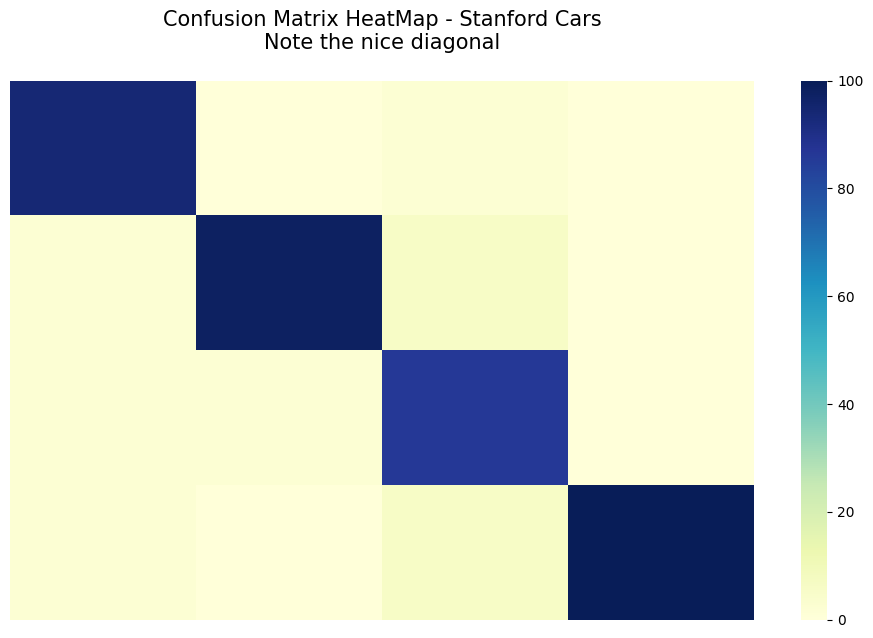

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(comparison['Predictions'],comparison['Actual'])
print('\n Confusion Matrix :- \n')
print(cm)
print("")

# Plot Confusion matrix
f, ax = plt.subplots(figsize=(12,7))
sns.heatmap(cm,annot = False, linewidths=0,linecolor="blue",fmt=".0f",ax=ax,cmap='YlGnBu')
# plt.xlabel('Actual Classes', fontsize = 15)
# plt.ylabel('Predicted Classes', fontsize = 15)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.title('Confusion Matrix HeatMap - Stanford Cars\nNote the nice diagonal\n', fontsize = 15)
plt.show()

In [83]:
# Making single image predictions

from PIL import Image

def single_image_prediction(path, n = 5):
    '''
    1. read image
    2. resize
    3. reshape
    4. pass to model
    5. generate top 3 predictions
    6. Display image and predictions with confidence levels    
    '''
    # read path and show image
    img_ = Image.open(path)
    plt.imshow(img_)
    plt.show()   
    
    # resize and reshape
        
    img_ = img_.resize(IMG_SIZE)
    img_ = np.array(img_).reshape((1,IMG_SIZE[0],IMG_SIZE[1],3 ))
    
    # run the model and make the prediction
    function_pred = model.predict(img_,verbose=1, steps = None)
    print(function_pred)
    
    # rep = pd.DataFrame(index = range(0,4))
    # rep['probabilities'] = function_pred[0]
    # rep = rep.reset_index(drop = False)
    # rep['Class Name']   = rep['index'].apply(labels.get)
    # rep.drop('index', axis = 1, inplace = True)
    
    # rep = rep.sort_values(by = 'probabilities', ascending = False).head(n)
    # rep = rep[['Class Name', 'probabilities']]
    
    # display(rep)
    
    
    # display(pd.DataFrame(prediction).T)
    print('all done')
    return
#####################################################    

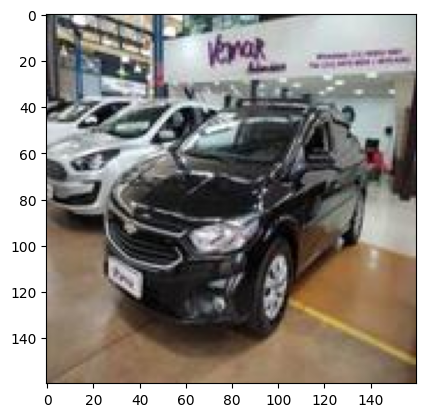

1/1 [==============================] - 0s 28ms/step
[[0.10148007 0.04083114 0.08809413 0.76959467]]
all done


In [88]:
# path = '../input/stanford-cars-augmented-balanced/Augmented_Balanced_Stanford_Car_Images_Uncropped/Test_Images/Jaguar XK XKR 2012/Test_01_03025.jpg'
path = 'dataset\\validation\\chevrolet-onix\\0001B4AAC3.jpg' # hummer
single_image_prediction(path,5)